# 0.- **Warnings**

This notebook cannot be run as it is. It makes use of downloaded data that might be later specified where and how to get the data. If not found, write to a maintainer to get directions

# 1.- Imports

In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

import quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *


from analytic_plots import *

import matplotlib

import astropy.units as u
import time
from scipy import sparse as sps
from astropy.coordinates import SkyCoord
import healpy as hp
import pickle
from tqdm import trange

from astroquery.gaia import Gaia

# Ipython magics
%load_ext autoreload
%autoreload 2
#%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload

DATA_FOLDER = '../../data/'
ARCHIVE_FOLDER = DATA_FOLDER+'gaia_archives_data/'
PICKLE_FOLDER = DATA_FOLDER+'pickle_data/'
FIG_FOLDER = '../figures/'

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# 2.- Satellite and scanner:

In [2]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 365*5
my_dt = 1/24/4 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [3]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(0.5) ,double_telescope=double_telescope) 
print('Scanner created')

Scanner created


# 3.- Some functions

In [12]:
# Functions usefull for this bit:
def generate_angles_of_sources(num_sources):
    # Warning be carefull to what you use to get alpha/delta from vector
    times_for_source = np.linspace(t_init, t_end, num=num_sources, endpoint=True)
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) *0
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha +noise[0], a_P+noise[1], a_F+noise[2]]
        deltas += [delta +noise[3], d_P+noise[4], d_F+noise[5]]
    return alphas, deltas


def generate_telescope_positions(num_points = 10000):
    # Generate telescopes positions
    alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
    for t in np.linspace(t_init, t_end, num=num_points):
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas_P.append(a_P)
        deltas_P.append(d_P)
        alphas_F.append(a_F)
        deltas_F.append(d_F)
    return alphas_P, deltas_P, alphas_F, deltas_F

def transform_twoPi_into_halfPi(deltas):
    deltas = np.array(deltas)
    to_modify_indices = np.where(deltas>np.pi)[0]
    deltas[to_modify_indices] -= 2*np.pi
    # print('lalala:', to_modify_indices)
    return deltas

# 4.- Visualize scanned zones

### 4.1 Generate coordinates

In [13]:
generate_telescope_positions(num_points=3)

([0.007864217063711968, 5.847255029757979, 5.341850083340825],
 [-1.0585528760760674, -0.5038907278627265, 0.7761577381017861],
 [5.370800440520091, 2.1991494225626265, 2.6786733673014242],
 [0.6417833269134682, -0.6891031028760581, 0.4297442552817129])

In [14]:
# alphas, deltas = generate_angles_of_sources()
alphas_P, deltas_P, alphas_F, deltas_F = generate_telescope_positions(num_points = int(5e4))

In [15]:
alphas_P = np.array(alphas_P)
alphas_P.shape

(50000,)

In [16]:
alphas_P = ft.zero_to_two_pi_to_minus_pi_pi(np.array(alphas_P))
alphas_F = ft.zero_to_two_pi_to_minus_pi_pi(np.array(alphas_F))

deltas_P = transform_twoPi_into_halfPi(deltas_P)
deltas_F = transform_twoPi_into_halfPi(deltas_F)

### 4.2 Traditional plots

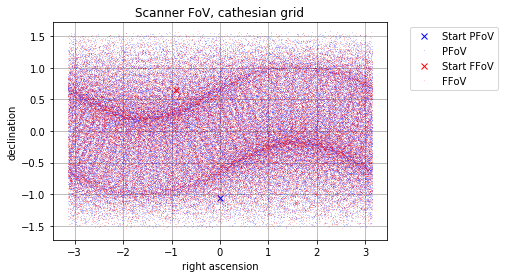

Plotted first plot


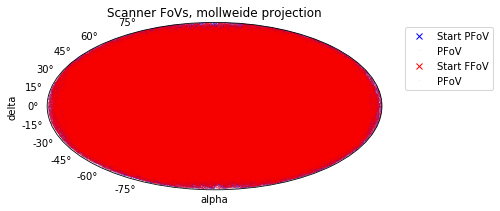

Plotted second plot


/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


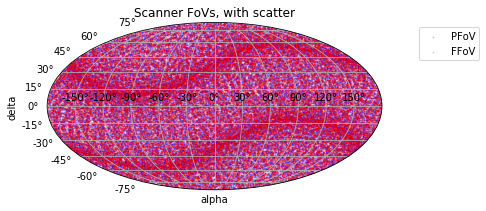

Plotted third plot


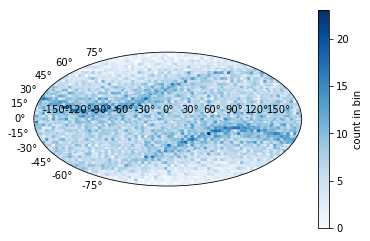

Plotted fourth plot


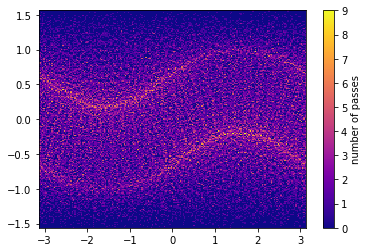

In [19]:
a_min, a_max = (0,-1)

fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV', alpha=0.2)
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='FFoV', alpha=0.2)

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')"""

plt.title("Scanner FoV, cathesian grid")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('right ascension'), plt.ylabel('declination')
plt.show()
fig.savefig(FIG_FOLDER+'/tmp/carthesian_scanning_law.png')

print('Plotted first plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV', alpha=0.1)
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='PFoV', alpha=0.1)

# plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], marker='.')

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')"""

plt.title("Scanner FoVs, mollweide projection")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig(FIG_FOLDER+'/tmp/Mollweide_scanner_positions')


print('Plotted second plot')
# ------------------------------ Separation  ----------------------------------------------

fig = plt.figure()
plt.subplot(111, projection="mollweide")
#plt.plot(aplhas[0], deltas[0], 's')
# plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
# plt.plot(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 'b,', label='PFoV', alpha=0.1)
# plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV', linestyle="None")
# plt.plot(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 'r,', label='PFoV', alpha=0.1)

plt.scatter(alphas_P[a_min : a_max], deltas_P[a_min : a_max], 
            marker='.', color='b', s=3, label='PFoV', alpha=0.2)
plt.scatter(alphas_F[a_min : a_max], deltas_F[a_min : a_max], 
            marker='.', color='r',s=3, label='FFoV', alpha=0.2)

"""plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'g,')"""

plt.title("Scanner FoVs, with scatter")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()
fig.savefig(FIG_FOLDER+'/tmp/Mollweide_scanner_positions')


print('Plotted third plot')
# ------------------------------ Separation  ----------------------------------------------
fig = plt.figure()
plt.subplot(111, projection="mollweide")
plt.hexbin(alphas_P[a_min : a_max], deltas_P[a_min : a_max], gridsize=90, cmap='Blues')
cb = plt.colorbar(label='count in bin')
plt.show()


print('Plotted fourth plot')
# ------------------------------ Separation  ----------------------------------------------
fig = plt.figure()
plt.subplot(111, projection=None)
plt.hist2d(alphas_P[a_min : a_max], deltas_P[a_min : a_max], bins=200, cmap='plasma')
cb = plt.colorbar(label='number of passes')
plt.show()
a=2;

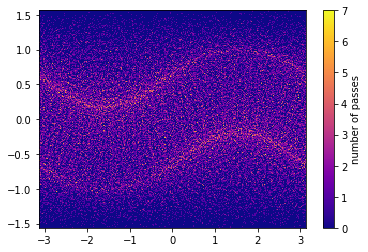

In [20]:
fig = plt.figure()
plt.subplot(111, projection=None)
plt.hist2d(alphas_P[a_min : a_max], deltas_P[a_min : a_max], bins=250, cmap='plasma')
cb = plt.colorbar(label='number of passes')
plt.show()
a=2;

### 4.3 Visualizaton healpy

In [21]:
def cat2hpx(ra, dec, nside):
    """
    from --> https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
    Convert a array of coordinates to a HEALPix map of number counts per resolution
    element.

    :param alpha: [float][rad] right ascencion (0-2*pi)
    :param delta: [float][rad] declination
    :param nside : [int] HEALPix nside of the target map

    :returns hpx_map: [ndarray] HEALPix map of the catalogue number counts in Galactic coordinates
    """

    my_coordinates = SkyCoord(ra=ra, dec=dec, frame='icrs', unit='rad')
    ra, dec = my_coordinates.icrs.ra.value, my_coordinates.icrs.dec.value

    # conver to theta, phi
    theta = np.radians(90. - dec)
    phi = np.radians(ra)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta=theta, phi=phi)

    idx, counts = np.unique(indices, return_counts=True)
    
    # fill the fullsky map
    npix = hp.nside2npix(nside)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

<Figure size 432x288 with 0 Axes>

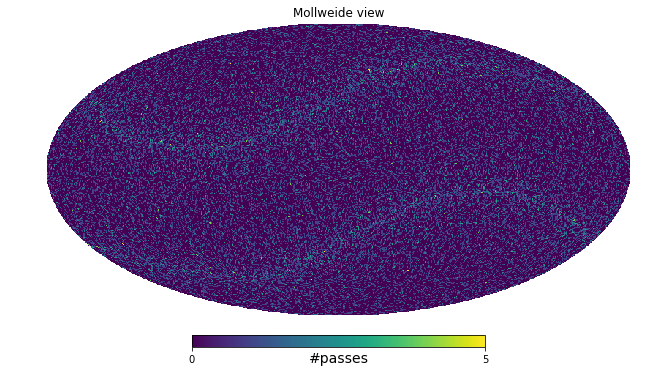

In [22]:
hpx_map = cat2hpx(np.array(alphas_P)-np.pi, np.array(deltas_P), nside=100)
fig = plt.figure()
hp.mollview(map=hpx_map, flip='astro', unit='#passes')
plt.savefig(FIG_FOLDER+'/tmp/healpy_FoV_map.png')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/zampieri/anaconda3/lib/python3.6/site-packages/healpy/projaxes.py:416: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


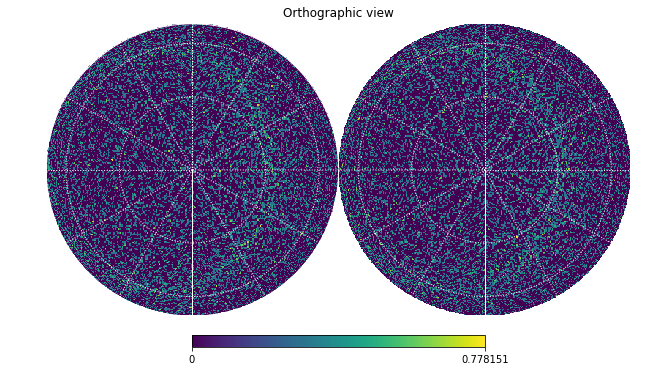

In [23]:
hp.orthview(np.log10(hpx_map+1), rot=[0, 90])
hp.graticule(color='white')

# 5.- Create and scan sources:

### 5.1 Create sources

In [ ]:
# create soures from that: 
num_sources = 50
alphas = np.random.rand(num_sources)*360
deltas = np.random.rand(num_sources)*360
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 10, 10, 10, 10))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

### 5.2 Scan sources

In [15]:
obs_times = []
calc_sources = []
real_sources = []
scanned_etas, scanned_zetas = ([], [])
for i in trange(len(sources)):
    s = sources[i]
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    """print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))"""
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        # print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        scanned_etas += my_scanner.eta_scanned
        scanned_zetas += my_scanner.zeta_scanned
        # calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
sources = real_sources
obs_times = obs_times

100%|██████████| 50/50 [03:11<00:00,  4.14s/it]


### 5.3 Plot scanned sources:

In [16]:
scanned_ra, scanned_dec = ([], [])
for t in obs_times:
    attitude = gaia.func_attitude(t)
    ra, dec = generate_observation_wrt_attitude(attitude)
    scanned_ra.append(ra)
    scanned_dec.append(dec)

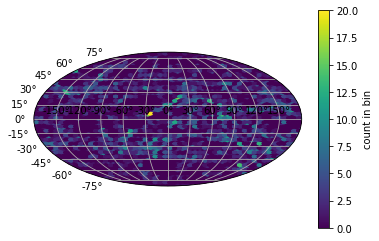

In [17]:
ra_to_plot = np.array(scanned_ra)-np.pi
dec_to_plot = transform_twoPi_into_halfPi(scanned_dec)

fig = plt.figure()

plt.subplot(111, projection="mollweide")
plt.hexbin(ra_to_plot, dec_to_plot, gridsize=60) # , cmap='Blues'
plt.grid()
cb = plt.colorbar(label='count in bin')
fig.savefig(FIG_FOLDER+'/tmp/scanned_sky.png')

### 5.4 Save scanned sources and retrieve them:

In [74]:
# note that the data is not on github, but can be created with the following command
with open(PICKLE_FOLDER+'5000_scan2.p', 'wb') as handle:
    # pickle.dump((scanned_ra, scanned_dec), handle, protocol=pickle.HIGHEST_PROTOCOL)
    pass

scanned_ra, scanned_dec = pickle.load( open( PICKLE_FOLDER+'5000_scan.p', "rb" ) )

# 6.- Get sources from gaia-archives

Do the query to gaia archive:

In [19]:
str_query = "SELECT \
    TOP 10000 source_id,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity \
    FROM gaiadr2.gaia_source \
    WHERE parallax_over_error>10 \
        AND phot_g_mean_flux_over_error>50 \
        AND phot_bp_mean_flux_over_error>20 \
        AND phot_rp_mean_flux_over_error>20 \
        AND phot_bp_rp_excess_factor<(1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)) \
        AND phot_bp_rp_excess_factor>(1+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)) \
        AND visibility_periods_used>8 \
        AND astrometric_excess_noise<1 \
    ORDER BY random_index;"

# job = Gaia.launch_job_async(str_query, dump_to_file=True)
# job.get_results()

### 6.1 Get raw astrometric params

In [75]:
df = pd.read_csv(ARCHIVE_FOLDER+"subsampled_10000_sources.csv")


In [76]:
# df = pd.read_csv(ARCHIVE_FOLDER+"subsampled_10000_v2.csv")
# units are: ra[deg], dec [deg], parallax[mas], pmra[mas/year], pmdec[mas/year], radial_velocity
df.head(1)

,source_id,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity
0,5435526445919095424,44,149.461823,-33.987084,0.536572,-6.627292,-0.107981,NaN


### 6.2 Visualize results

In [77]:
ra_archive, dec_archive = np.radians(df['ra'].values), np.radians(df['dec'].values)
ra_to_plot = ft.zero_to_two_pi_to_minus_pi_pi(np.array(ra_archive))
dec_to_plot = dec_archive # transform_twoPi_into_halfPi(dec_archive)

In [78]:
ra_to_plot.min()

-3.1411073335095603

In [79]:
ra_to_plot.max()

3.1392418237556647

In [80]:
dec_to_plot.min(), dec_to_plot.max()

(-1.5621440909555162, 1.5518271652652174)

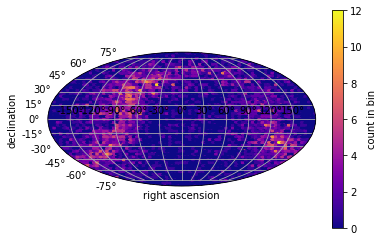

In [81]:
fig = plt.figure()
plt.subplot(111, projection="mollweide")#"mollweide")
# plt.plot(ra_to_plot, dec_to_plot, 'r,', label='sources', alpha=1)
# plt.scatter(ra_to_plot, dec_to_plot,  marker='.', color='r', s=3, label='sources', alpha=0.2)
# plt.hexbin(ra_to_plot, dec_to_plot, gridsize=90) # , cmap='Blues'
plt.grid()
plt.xlabel('right ascension')
plt.ylabel('declination')
"""plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi/2,np.pi/2))"""
plt.hexbin(ra_to_plot, dec_to_plot, gridsize=90, cmap='plasma')
cb = plt.colorbar(label='count in bin')
fig.savefig(FIG_FOLDER+'/tmp/archive_sky.png')

<Figure size 432x288 with 0 Axes>

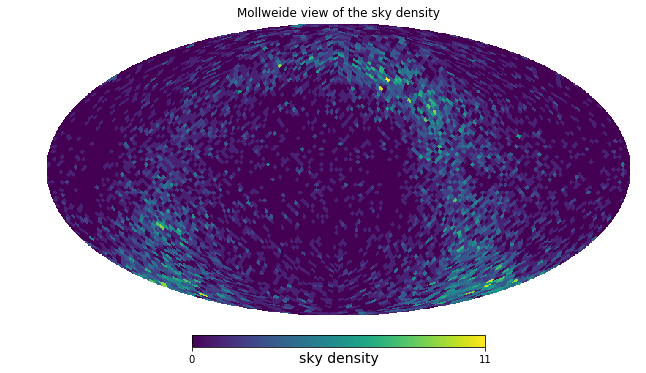

In [82]:
hpx_map = cat2hpx(np.array(ra_to_plot), np.array(dec_to_plot), nside=30)
fig = plt.figure()
hp.mollview(map=hpx_map, flip='astro', unit='sky density', title='Mollweide view of the sky density')
plt.savefig(FIG_FOLDER+'/tmp/healpy_scanned_sky_density_map.png')

In [45]:
df.describe()
df.isnull().any()

source_id          False
random_index       False
ra                 False
dec                False
parallax           False
pmra               False
pmdec              False
radial_velocity     True
dtype: bool

### 6.3 Scan all sources:
Can be a long taks...

In [46]:
obs_times = []
calc_sources = []
real_sources = []
obs_time_per_source = []
for i in trange(df.shape[0]):
    params = df.iloc[i].copy()
    s = Source(str(i), params['ra'], params['dec'], params['parallax'], params['pmra'], params['pmdec'],0)
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    # print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    """print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))"""
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        obs_time_per_source.append(np.sort(my_scanner.obs_times).copy())
    del s
sources = real_sources
obs_times = obs_times

  0%|          | 0/10000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [47]:
# add sources to dataframe
df['obs_times'] = pd.Series(obs_time_per_source)

In [48]:
df.head(1)

,source_id,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity,obs_times
0,5435526445919095424,44,149.461823,-33.987084,0.536572,-6.627292,-0.107981,NaN,NaN


In [49]:
len(obs_time_per_source)

0

### 6.4 Save and retrieve results:

In [88]:
# note that the data is not on github, but can be created with the following command
with open(PICKLE_FOLDER+'10000_scanned_sources_5years_df2.p', 'wb') as handle:
    # pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pass

In [89]:
df = pickle.load( open( PICKLE_FOLDER+'10000_scanned_sources_5years_df.p', "rb" ) )

In [90]:
df.head(1)

,source_id,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity,obs_times
0,5435526445919095424,44,149.461823,-33.987084,0.536572,-6.627292,-0.107981,NaN,"[47.7357406463899, 47.80970033353229, 47.98574..."


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
source_id          10000 non-null int64
random_index       10000 non-null int64
ra                 10000 non-null float64
dec                10000 non-null float64
parallax           10000 non-null float64
pmra               10000 non-null float64
pmdec              10000 non-null float64
radial_velocity    795 non-null float64
obs_times          10000 non-null object
dtypes: float64(6), int64(2), object(1)
memory usage: 703.2+ KB


### 6.5 Visualize results

In [92]:
ra_to_plot = ft.zero_to_two_pi_to_minus_pi_pi(np.array(df['ra']), unit='degrees')

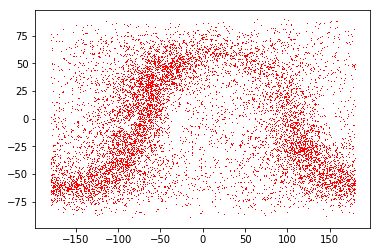

In [93]:
plt.plot(ra_to_plot, df['dec'],'r,')

##### 6.5.1 Nomber of observations

In [94]:
observed_times = np.concatenate(df['obs_times'].values).ravel()

In [95]:
scanned_ra, scanned_dec = ([], [])
for i in trange(observed_times.shape[0]):
    t = observed_times[i]
    attitude = gaia.func_attitude(t)
    ra, dec = generate_observation_wrt_attitude(attitude)
    scanned_ra.append(ra)
    scanned_dec.append(dec)

100%|██████████| 1154301/1154301 [05:27<00:00, 3520.02it/s]


/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


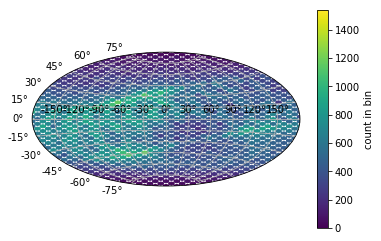

In [96]:
ra_to_plot = ft.zero_to_two_pi_to_minus_pi_pi(np.array(scanned_ra))
dec_to_plot = transform_twoPi_into_halfPi(scanned_dec)

fig = plt.figure()
plt.title('number of observations')
plt.subplot(111, projection="aitoff")
plt.hexbin(ra_to_plot, dec_to_plot, gridsize=50) # , cmap='Blues'
plt.grid()
cb = plt.colorbar(label='count in bin')
fig.savefig(FIG_FOLDER+'/tmp/archive_scanned_sky0.png')

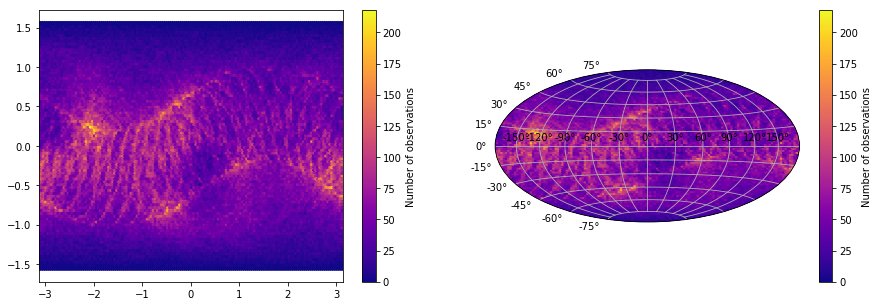

In [97]:
cmap = 'plasma'
label_colorbar = 'Number of observations'

ra_to_plot = ft.zero_to_two_pi_to_minus_pi_pi(np.array(scanned_ra))
dec_to_plot = transform_twoPi_into_halfPi(scanned_dec)

fig = plt.figure(figsize=(15,5))
plt.title('number of observations')
plt.subplot(121, projection=None)
plt.hexbin(ra_to_plot, dec_to_plot, gridsize=150, cmap=cmap) # , cmap='Blues'
# plt.grid()
plt.xlim(-np.pi,np.pi)
cb = plt.colorbar(label=label_colorbar)
# second subplot
plt.subplot(122, projection="hammer")
plt.hexbin(ra_to_plot, dec_to_plot, gridsize=150, cmap=cmap) # , cmap='Blues'
plt.grid()
cb = plt.colorbar(label=label_colorbar)

# save figure
fig.savefig(FIG_FOLDER+'/tmp/archive_scanned_sky_num_of_observations.png')

In [98]:
len(ra_to_plot)

1154301

(-3.141592653589793, 3.141592653589793)

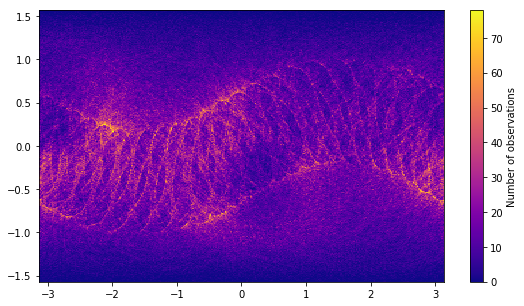

In [99]:
fig = plt.figure(figsize=(20,5))
plt.title('number of observations')
plt.subplot(121, projection=None)
plt.hist2d(ra_to_plot, dec_to_plot, bins=300, cmap=cmap) # , cmap='Blues'
cb = plt.colorbar(label=label_colorbar)
# plt.grid()
plt.xlim(-np.pi,np.pi)

##### 6.5.2 Nomber of observations per source

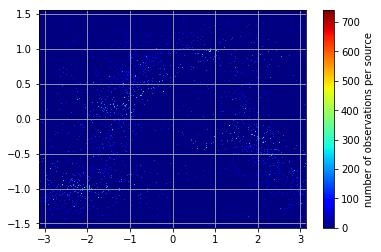

In [100]:
ra_to_plot2 = ft.zero_to_two_pi_to_minus_pi_pi(np.radians(np.array(df['ra'])))
dec_to_plot2 = np.radians(df['dec'])
weights = df['obs_times'].apply(lambda x: len(x))
# weights = np.log(weights+1)

fig = plt.figure()

plt.subplot(111, projection=None)

plt.hist2d(ra_to_plot2, dec_to_plot2, bins=600, weights=weights, cmap='jet') # , norm=matplotlib.colors.LogNorm()
cb = plt.colorbar(label='number of observations per source')
# plt.hexbin(ra_to_plot, dec_to_plot, gridsize=300, C=np.array(df['obs_times']), reduce_C_function=len)

plt.grid()
# cb = plt.colorbar(label='number of observations')
fig.savefig(FIG_FOLDER+'/tmp/archive_scanned_sky_observation_per_source.png')

<Figure size 432x288 with 0 Axes>

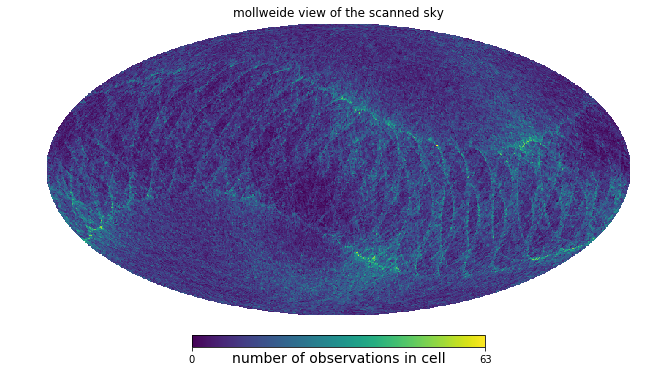

In [102]:
hpx_map = cat2hpx(np.array(ra_to_plot), np.array(dec_to_plot), nside=90)
fig = plt.figure()
hp.mollview(map=hpx_map, flip='astro', unit='number of observations in cell', title='mollweide view of the scanned sky', 
            cmap=None)
plt.savefig(FIG_FOLDER+'/tmp/healpy_scanned_sky_density_map.png')